In [1]:
# importing libraries used throughout simulator
from random import uniform
import pandas as pd
import numpy as np
import warnings

from pybaseball import pitching_stats_bref
from pybaseball import batting_stats_bref

# import Machine Learning Algorithm to fetch predicted stats
from modules.machine_learning import mainGetPredictions as ml

# import schedule from MLB_2019_Schedule
import Simulator.MLB_2019_Schedule as MLB

from IPython.display import HTML as html_print
import matplotlib.pyplot as plt

# ignore warnings in code
warnings.simplefilter("ignore")

In [2]:
# class for season
class Season:
    # initialization of class instance variables
    def __init__(self, teamName):
        self.games = 1
        self.teamName = teamName
        self.data_df = pd.DataFrame(columns={'Game', 'Home Team Score', 'Away Team Score', 'Home Team', 'Away Team',
                                             'League'})

    # method to run a seasons worth of games for any given team
    def playSeason(self):
        schedule = MLB.getTeamSchedule(self.teamName)               # fetching season schedule for a given team
        home = MLB.homeOrAway(schedule)                             # check which team is at home for each game
        games = MLB.checkFirstBit(schedule)                         # cleaning season schedule
        opposingTeam = iter(games)                                  # declare iterator for games in the season
        gamesPlayed = 0
        teams_df = pd.DataFrame(columns={"Home Team", "Away Team", "League"})   # create a DataFrame to me merged into output
        while gamesPlayed <= 162:
            try:
                current = next(opposingTeam)
                if home[gamesPlayed] == "True":                     # arrange teams in 'Home Team', 'Away Team' columns
                    teams_df = teams_df.append({"Home Team": self.teamName, "Away Team": MLB.toName(current),
                                                "League": TeamsPlaying(self.teamName, MLB.toName(current)).gameLeague()},
                                               ignore_index=True)
                elif home[gamesPlayed] == "False":
                    teams_df = teams_df.append({"Home Team": MLB.toName(current), "Away Team": self.teamName,
                                                "League": TeamsPlaying(MLB.toName(current), self.teamName).gameLeague()},
                                               ignore_index=True)
                gamesPlayed = gamesPlayed + 1
            except StopIteration:
                break
        return teams_df

    def nextGame(self):
        teams_df = self.playSeason()                            # fetching Data Frame of season outcomes
        self.data_df = self.data_df[['Game', 'Home Team Score', 'Away Team Score', 'Home Team', 'Away Team', 'League']]
        self.data_df = self.data_df.append({'Game': self.games, 'Home Team Score': game.score[0],
                                            'Away Team Score': game.score[1]}, ignore_index=True)
        #
        # print("Home team: " + self.teamName + " Away Team: " + )
        #
        self.data_df.update(teams_df)                           # update the Data frame with data from season outcomes
        pd.set_option("display.max_rows", 162)
        pd.set_option("display.max_columns", 7)
        self.games = self.games + 1

In [3]:
# class for game (parent class of inning)
class Game:
    # initialization of class instance variables
    def __init__(self):
        self.inning = 1
        self.outs = 0
        self.score = [0, 0]
        self.top = False

    # method for adding runs scored for each team
    def runScored(self):
        if self.top:                        # if top of the inning points awarded to the team of index zero
            self.score[1] = self.score[1] + 1
        else:                               # points awarded to team of index one in the bottom of innings
            self.score[0] = self.score[0] + 1

    # method for behavior of an out in the game
    def out(self):
        self.outs = self.outs + 1           # add one to the out count
        if self.outs == 3:                  # at three outs switch the inning, resetting outs to zero
            self.outs = 0
            inning.inningSwitch()
            if not game.top:                # if its the bottom of the inning, start next inning
                self.inning = self.inning + 1

        if self.inning >= 10 and self.score[0] != self.score[1]:        # if 10 innings reached and not tied
            season.nextGame()                                           # game ends, go to next game
            self.endGame()
        elif self.inning == 10 and self.score[0] == self.score[1]:      # otherwise, keep going until one team wins
            pass

    # method to reset the game to starting parameters
    def endGame(self):
        self.inning = 1
        self.outs = 0
        self.score = [0, 0]
        self.top = False

In [4]:
# class for innings (child class of game)
class Inning(Game):
    # method to switch between top and bottom of inning
    def inningSwitch(self):                 # sets outs back to zero and switches between top and bottom of inning
        if game.top:
            self.outs = 0
            self.bottomOf()
        else:
            self.outs = 0
            self.topOf()

    # mutator to change the status of the inning (top or bottom of the inning)
    def topOf(self):                        # if top of inning, set top to true
        game.top = True

    # mutator to change the status of the inning (top or bottom of the inning)
    def bottomOf(self):                     # if bottom of inning, sets top to false
        game.top = False

In [5]:
# class for all behaviors/stats of batters
class Batter:
    # initialization of instance variables
    def __init__(self):
        self.strikes = 0
        self.balls = 0

    # method for behavior of a strike
    def strike(self):
        self.strikes = self.strikes + 1     # add one to strike count
        if self.strikes == 3:               # if batter has 3 strikes, batter is out
            game.out()
            self.nextBatter()               # calls function to get stats on the next batter

    # method for behavior of a ball
    def ball(self):
        self.balls = self.balls + 1         # add one to ball count
        if self.balls == 4:                 # if batter gets 4 balls
            self.single()                   # walk to first
            self.nextBatter()               # calls function to get the next batters stats

    # method to fetch next batter statistics
    def nextBatter(self):
        self.strikes = 0                    # resets strike/ball count to zero
        self.balls = 0
        pass                                # get next batters statistics

    # method for behavior of a single hit
    def single(self):
        if bases.basesLoaded:               # bases will stay loaded and one run will be scored
            game.runScored()
        else:
            if bases.third:
                if not bases.second:        # if second base is empty, third base will become empty
                    bases.third = False
                game.runScored()            # run scored and the player from second will occupy third if true
            if bases.second:
                if not bases.first:         # if first base is empty, second base will become empty
                    bases.second = False
                bases.third = True          # otherwise, it will be occupied by the player that was on first
            if bases.first:                 # first will stay occupied by the player who was batting
                bases.second = True
        bases.first = True                  # player guaranteed to be on first

    # method for behavior of a double hit
    def double(self):
        if bases.basesLoaded:               # if bases loaded, two players will score and first will become empty
            bases.first = False
            game.runScored()
            game.runScored()
        else:
            if bases.third:
                if not bases.first:         # if first is empty, third will become empty
                    bases.third = False
                game.runScored()            # run scored and the player from first will occupy third if true
            if bases.first:                 # first will no longer be occupied
                bases.first = False
                bases.third = True
            if bases.second:                # second base will stay occupied by player who was batting
                game.runScored()
        bases.second = True                 # player guaranteed to be on second

    # method for behavior of a triple hit
    def triple(self):
        if bases.basesLoaded:               # all players on base will score a run
            bases.first = False
            bases.second = False
            bases.Third = False
            game.runScored()
            game.runScored()
            game.runScored()
        else:
            if bases.third:                 # run scored by occupant, stays occupied by the player who was batting
                game.runScored()
            if bases.first:                 # player on first will have scored
                bases.first = False
                game.runScored()
            if bases.second:                # player on second will have scored
                bases.second = False
                game.runScored()
        bases.third = True                  # player guaranteed to be on third

    # method for behavior of a home run hit
    def homeRun(self):
        if bases.basesLoaded:               # all players on base and batter will score a run
            bases.first = False
            bases.second = False
            bases.third = False
            game.runScored()
            game.runScored()
            game.runScored()
            game.runScored()
        else:
            if bases.first:                 # first becomes empty and a run is scored
                bases.first = False
                game.runScored()
            if bases.second:                # second becomes empty and a run is scored
                bases.second = False
                game.runScored()
            if bases.third:                 # third becomes empty and a run is scored
                bases.third = False
                game.runScored()
            game.runScored()                # run scored by batter

In [6]:
# class to track base status
class Bases:
    # initialization of instance variables
    def __init__(self):
        self.first = False
        self.second = False
        self.third = False
        self.basesLoaded = False

    # method to simulate loaded bases
    def loadedBases(self):                  # if there are players on every base, bases are loaded
        if self.first and self.second and self.third:
            self.basesLoaded = True
        else:                               # otherwise bases are not loaded
            self.basesLoaded = False

    # method to output which bases are occupied
    def playerOn(self):
        self.loadedBases()                  # check if bases are loaded
        if not self.basesLoaded:            # if they aren't
            if self.first:                  # check all individual bases to see if they are occupied
                print("Player on first")
            else:
                print("First is empty")
            if self.second:
                print("Player on Second")
            else:
                print("Second is empty")
            if self.third:
                print("Player on third")
            else:
                print("Third is empty")
        else:                               # otherwise, all bases are loaded
            print("Bases Loaded")

In [7]:
# class for Teams
class Team:
    # initialization of instance variables
    def __init__(self, teamName, teamCity, league):
        self.team = teamCity
        self.league = league
        self.teamName = teamName

    # method to fetch predicted team stats from MLM
    def getPredictedStats(self, start, end, trainRange, toPredictFeatures, showProcess, method):
        predictedStats = ml.getPredictions(start, end, trainRange, toPredictFeatures, showProcess, method)
        return predictedStats

    # method to fetch batting roster of a given team
    def getBattingRoster(self):
        batting = batting_stats_bref(2018)
        batting_df = pd.DataFrame(batting)
        batting_df.set_index("Tm", inplace=True)
        homeBat_df = batting_df.loc[self.team]
        return homeBat_df

    # method to fetch pitching roster of a given team
    def getPitchingRoster(self):
        pitching = pitching_stats_bref(2018)
        pitching_df = pd.DataFrame(pitching)
        pitching_df.set_index("Tm", inplace=True)
        homePitch_df = pitching_df.loc[self.team]
        return homePitch_df

    # accessor to return league team plays in
    def getLeague(self):
        league = self.league
        return league

    # accessor to return the name of the team
    def getTeamName(self):
        teamName = self.teamName
        return teamName

In [8]:
# class for teams playing in a particular game (parent class to Home and Away)
class TeamsPlaying:
    # initialization of instance varaibles
    def __init__(self, homeTeam, awayTeam):
        self.home = homeTeam
        self.away = awayTeam

    # accessor to return the home team
    def getHomeTeam(self):
        return self.home

    # accessor to return the away team
    def getAwayTeam(self):
        return self.away

    # method to return the league in which a game falls under (based on the individual leagues of teams playing
    def gameLeague(self):
        homeLeague = ""
        awayLeague = ""
        for team in range(len(NL)):                     # iterate through NL league
            if self.home == NL[team].getTeamName():     # if home team is in NL, set homeLeague to NL
                homeLeague = NL[team].getLeague()
            if self.away == NL[team].getTeamName():     # if away team is in NL, set awayLeague to NL
                awayLeague = NL[team].getLeague()
        for team in range(len(AL)):                     # iterate through AL league
            if self.home == AL[team].getTeamName():     # if home team is in AL, set homeLeague to AL
                homeLeague = AL[team].getLeague()
            if self.away == AL[team].getTeamName():     # if away team is in AL, set awayLeague to AL
                awayLeague = AL[team].getLeague()
        if homeLeague == "MLB-NL" and awayLeague == "MLB-NL":   # if both teams are in NL, game league is NL
            league = "MLB-NL"
        elif homeLeague == "MLB-AL" and awayLeague == "MLB-AL": # if both teams are in AL, game league is AL
            league = "MLB-AL"
        else:                               # if both teams are in different leagues, game league is Inter-league
            league = "Inter-League"
        return league

In [9]:
# class for home games (child class of Team)
class Home(TeamsPlaying):
    # accessor to return stadium adjustment for home team
    def getStadiumAdjust(self):
        pass

In [10]:
# class for away games (child class of Team)
class Away(TeamsPlaying):
    # accessor to return stadium adjustment for away team
    def getStadiumAdjust(self):
        pass

In [11]:
# class for player (Parent class to Pitcher, Reliever, Positional, and DesignatedHitter)
class Player:
    # initialization of instance variables
    def __init__(self, playerID):
        self.playerID = playerID

    # method to fetch the number of innings pitched by a pitcher in a season
    def inningsPitched(self):
        pitching = pitching_stats_bref(2018)
        pitching_df = pd.DataFrame(pitching)
        pitching_df.set_index("Name", inplace=True)
        pitch_df = pitching_df.loc[self.playerID]
        IP = pitch_df.loc['IP']
        return IP

    # method to distinguish between starting pitchers and relievers
    def position(self):
        global player_df
        IP = self.inningsPitched()
        if 10 < IP < 60:            # if player has pitched more than 10 innings but less than 60, player is a reliever
            player_df = Reliever.getRelieverStats(self.playerID)
        elif IP > 60:               # if player has pitched more than 60 innings, player is a starting pitcher
            player_df = Pitcher.getPitcherStats(self.playerID)
        else:                       # if player has pitched less than 10 innings, player is a positional player
            Positional(self.playerID)
        return player_df

In [12]:
# class for pitchers (child class of Player)
class Pitcher(Player):
    # method to fetch starting pitcher statistics, returning data frame
    def getPitcherStats(self):
        pitcher = pitching_stats_bref(2018)
        pitcher_df = pd.DataFrame(pitcher)
        pitcher_df.set_index("Name", inplace=True)
        player_df = pitcher_df.loc[self.playerID]
        return player_df

    # accessor to fetch a specific stat from the pitcher
    def getStat(self, stat):
        pitcher_stat = player_df.loc[stat]
        return pitcher_stat

In [13]:
# class for relievers (child class of Player)
class Reliever(Player):
    # method to fetch reliever statistics, returning data frame
    def getRelieverStats(self):
        reliever = pitching_stats_bref(2018)
        reliever_df = pd.DataFrame(reliever)
        reliever_df.set_index("Name", inplace=True)
        player_df = reliever_df.loc[self.playerID]
        return player_df

    # accessor to fetch a specific stat from the reliever
    def getStat(self, stat):
        player_stat = player_df.loc[stat]
        return player_stat

In [14]:
# class for positional player (child class of Player)
class Positional(Player):
    pass

In [15]:
# class for designated hitters (child class of Player)
class DesignatedHitter(Player):
    # method to fetch batter statistics, returning a data frame
    def getBatterStats(self):
        batter = batting_stats_bref(2018)
        batter_df = pd.DataFrame(batter)
        batter_df.set_index("Name", inplace=True)
        player_df = batter_df.loc[self.playerID]
        return player_df

    # accessor to fetch a specific stat from the batter
    def getStat(self, stat):
        player_stat = player_df.loc[stat]
        return player_stat

In [16]:
# get the run expectancy based on the state of runners on base compared to the number of outs
def getRunExpectancy():
    global RE
    if game.outs == 0:
        if not bases.first and not bases.second and not bases.third:    # No runners on base
            RE = 0.461                                                  # Run Expectancy
        elif bases.first and not bases.second and not bases.third:      # Runner only on first base
            RE = 0.831                                                  # Run Expectancy
        elif not bases.first and bases.second and not bases.third:      # Runner only on second base
            RE = 1.068                                                  # Run Expectancy
        elif not bases.first and not bases.second and bases.third:      # Runner only on third base
            RE = 1.426                                                  # Run Expectancy
        elif bases.first and bases.second and not bases.third:          # Runners on first and second
            RE = 1.373                                                  # Run Expectancy
        elif bases.first and not bases.second and bases.third:          # Runners on first and third
            RE = 1.798                                                  # Run Expectancy
        elif not bases.first and bases.second and bases.third:          # Runners on second and third
            RE = 1.920                                                  # Run Expectancy
        elif bases.basesLoaded:                                         # Bases Loaded
            RE = 2.282                                                  # Run Expectancy
    elif game.outs == 1:
        if not bases.first and not bases.second and not bases.third:    # No runners on base
            RE = 0.243                                                  # Run Expectancy
        elif bases.first and not bases.second and not bases.third:      # Runner only on first base
            RE = 0.489                                                  # Run Expectancy
        elif not bases.first and bases.second and not bases.third:      # Runner only on second base
            RE = 0.644                                                  # Run Expectancy
        elif not bases.first and not bases.second and bases.third:      # Runner only on third base
            RE = 0.865                                                  # Run Expectancy
        elif bases.first and bases.second and not bases.third:          # Runners on first and second
            RE = 0.908                                                  # Run Expectancy
        elif bases.first and not bases.second and bases.third:          # Runners on first and third
            RE = 1.140                                                  # Run Expectancy
        elif not bases.first and bases.second and bases.third:          # Runners on second and third
            RE = 1.352                                                  # Run Expectancy
        elif bases.basesLoaded:                                         # Bases Loaded
            RE = 1.520                                                  # Run Expectancy
    elif game.outs == 2:
        if not bases.first and not bases.second and not bases.third:    # No runners on base
            RE = 0.095                                                  # Run Expectancy
        elif bases.first and not bases.second and not bases.third:      # Runner only on first base
            RE = 0.214                                                  # Run Expectancy
        elif not bases.first and bases.second and not bases.third:      # Runner only on second base
            RE = 0.305                                                  # Run Expectancy
        elif not bases.first and not bases.second and bases.third:      # Runner only on third base
            RE = 0.413                                                  # Run Expectancy
        elif bases.first and bases.second and not bases.third:          # Runners on first and second
            RE = 0.343                                                  # Run Expectancy
        elif bases.first and not bases.second and bases.third:          # Runners on first and third
            RE = 0.471                                                  # Run Expectancy
        elif not bases.first and bases.second and bases.third:          # Runners on second and third
            RE = 0.570                                                  # Run Expectancy
        elif bases.basesLoaded:                                         # Bases Loaded
            RE = 0.736                                                  # Run Expectancy
    return RE

In [17]:
teamName = "BlueJays"

In [18]:
# initializing objects
season = Season(teamName)          # input name of specific team of interest
game = Game()
inning = Inning()
batter = Batter()
bases = Bases()

# Create objects for each team in the MLB-NL
Cubs = Team("Cubs", "Chicago", "MLB-NL")
Dodgers = Team("Dodgers", "Los Angeles", "MLB-NL")
Cardinals = Team("Cardinals", "St. Louis", "MLB-NL")
Mets = Team("Mets", "New York", "MLB-NL")
Pirates = Team("Pirates", "Pittsburgh", "MLB-NL")
Nationals = Team("Nationals", "Washington", "MLB-NL")
Braves = Team("Braves", "Atlanta", "MLB-NL")
Brewers = Team("Brewers", "Milwaukee", "MLB-NL")
Reds = Team("Reds", "Cincinnati", "MLB-NL")
Phillies = Team("Philies", "Philadelphia", "MLB-NL")
Giants = Team("Giants", "San Francisco", "MLB-NL")
Rockies = Team("Rockies", "Colorado", "MLB-NL")
Diamondbacks = Team("Diamondbacks", "Arizona", "MLB-NL")
Padres = Team("Padres", "San Diego", "MLB-NL")
Marlins = Team("Marlins", "Miami", "MLB-NL")

# Create objects for each team in the MLB-AL
Yankees = Team("Yankees", "New York", "MLB-AL")
RedSox = Team("RedSox", "Boston", "MLB-AL")
Indians = Team("Indians", "Cleveland", "MLB-AL")
Astros = Team("Astros", "Houston", "MLB-AL")
WhiteSox = Team("WhiteSox", "Chicago", "MLB-AL")
Athletics = Team("Athletics", "Oakland", "MLB-AL")
Orioles = Team("Orioles", "Baltimore", "MLB-AL")
Rays = Team("Rays", "Tampa Bay", "MLB-AL")
Angels = Team("Angels", "Los Angeles", "MLB-AL")
BlueJays = Team("BlueJays", "Toronto", "MLB-AL")
Twins = Team("Twins", "Minnesota", "MLB-AL")
Royals = Team("Royals", "Kansas City", "MLB-AL")
Mariners = Team("Mariners", "Seattle", "MLB-AL")
Rangers = Team("Rangers", "Texas", "MLB-AL")
Tigers = Team("Tigers", "Detroit", "MLB-AL")

# creating an array of team objects for all teams in NL
NL = np.array([Cubs, Dodgers, Cardinals, Mets, Pirates, Nationals, Braves, Brewers, Reds,
               Phillies, Giants, Rockies, Diamondbacks, Padres, Marlins])
# creating an array of team objects for all teams in AL
AL = np.array([Yankees, RedSox, Indians, Astros, WhiteSox, Athletics, Orioles, Rays, Angels,
               BlueJays, Twins, Royals, Mariners, Rangers, Tigers])


# run the game
while season.games < 163:
    swing = uniform(0.0, 1.0)
    if swing <= 0.635:                              # batters swing at 63.5% of all pitches
        strikeZone = uniform(0.0, 1.0)
        if strikeZone <= 0.45:                      # 45% of all pitches are inside the strike zone
            hit = uniform(0.0, 1.0)
            if hit <= 0.8075:                       # 80.75% of swings in strike zone will hit
                expectancy = getRunExpectancy()
                runChance = uniform(0.0, 3.0)
                if runChance <= expectancy:
                    game.runScored()
                else:
                    game.out()
            else:                                   # swing and miss, resulting in a strike
                batter.strike()
        else:                                       # not in strike zone but still swing, results in strike
            batter.strike()
    else:                                           # batter did not swing and not in strike zone, results in a ball
        batter.ball()
    if bases.first:
        throwOut = uniform(0.0, 1.0)
        if throwOut <= 0.3:
            game.out()
            bases.first = False
        else:
            pass
    elif bases.second:
        throwOut = uniform(0.0, 1.0)
        if throwOut <= 0.3:
            game.out()
            bases.second = False
        else:
            pass
    elif bases.third:
        throwOut = uniform(0.0, 1.0)
        if throwOut <= 0.3:
            game.out()
            bases.third = False
        else:
            pass

In [19]:
# colour the above graph - green for win and red for loss, yellow for draw
def colourWinsAndLosses(row):
    homeTeam = row['Home Team']
    awayTeam = row['Away Team']
    homeScore = row['Home Team Score']
    awayScore = row['Away Team Score']
    colour = ''
    if homeTeam == teamName:
        if homeScore > awayScore:
            colour = "#66a47b" # green (win)
        elif homeScore < awayScore:
            colour = "#da5353" # red (loss)
    else: # our team is away
        if homeScore < awayScore:
            colour = "#66a47b" # green (win)
        elif homeScore > awayScore:
            colour = "#da5353" # red (loss)
            
    fgColour = [f'color: {colour}' for cell in row]
    
    return fgColour

In [20]:
season.data_df.style.apply(colourWinsAndLosses, axis=1)

,Game,Home Team Score,Away Team Score,Home Team,Away Team,League
0,1,0,1,BlueJays,Tigers,MLB-AL
1,2,2,1,BlueJays,Tigers,MLB-AL
2,3,3,0,BlueJays,Tigers,MLB-AL
3,4,2,1,BlueJays,Tigers,MLB-AL
4,5,3,2,BlueJays,Orioles,MLB-AL
5,6,2,0,BlueJays,Orioles,MLB-AL
6,7,1,2,BlueJays,Orioles,MLB-AL
7,8,7,1,Indians,BlueJays,MLB-AL
8,9,1,3,Indians,BlueJays,MLB-AL
9,10,3,2,Indians,BlueJays,MLB-AL


In [21]:
def winsAndLosses(df):
    # find out the teams we played against
    records = {}
    # final dict will look something like this {"Astros": [1, 2]} # the first element in the list is wins and the other is losses
    # keep track of the wins and losses against each team
    for index, row in df.iterrows():
        homeTeam = row['Home Team']
        awayTeam = row['Away Team']
        homeScore = row['Home Team Score']
        awayScore = row['Away Team Score']
        if homeTeam == teamName:
            if awayTeam not in records:
                records[awayTeam] = [0, 0] # initialising the record against that team
            if homeScore > awayScore:
                records[awayTeam][0] += 1 # increase wins
            elif homeScore < awayScore:
                records[awayTeam][1] += 1# increase losses
        else: # our team is away
            if homeTeam not in records:
                records[homeTeam] = [0, 0] #initialising the record against that team
            if homeScore < awayScore:
                records[homeTeam][0] += 1
            elif homeScore > awayScore:
                records[homeTeam][1] += 1
    return records

In [22]:
records = winsAndLosses(season.data_df)
records

{'Tigers': [3, 4],
 'Orioles': [7, 12],
 'Indians': [4, 3],
 'RedSox': [15, 7],
 'Rays': [10, 9],
 'Twins': [3, 4],
 'Athletics': [5, 3],
 'Angels': [3, 4],
 'Rangers': [3, 3],
 'WhiteSox': [6, 3],
 'Rockies': [2, 1],
 'Yankees': [8, 11],
 'Diamondbacks': [3, 0],
 'Astros': [3, 3],
 'Royals': [4, 3],
 'Mariners': [1, 5],
 'Dodgers': [0, 3],
 'Braves': [2, 2]}

In [23]:
def maxAndMin(records):
    maxWinVal = records[list(records.keys())[0]][0]
    maxWinTeams = [] #records[list(records.keys())[0]]
    maxLoseVal = records[list(records.keys())[0]][1]
    maxLoseTeams = [] #records[list(records.keys())[0]]
    for element in list(records.items())[1:]:
        key = element[0]
        val = element[1]
        if val[0] > maxWinVal:
            maxWinVal = val[0]
        if val[1] > maxLoseVal:
            maxLoseVal = val[1]
    for key in records:
        if records[key][0] == maxWinVal:
            maxWinTeams.append(key)
        if records[key][1] == maxLoseVal:
            maxLoseTeams.append(key)
    return ((maxWinVal, maxWinTeams), (maxLoseVal, maxLoseTeams))

In [24]:
max_, min_ = maxAndMin(records)
maxWinVal, maxWinTeams = max_
maxLoseVal, maxLoseTeams = min_

In [25]:
def totalWinsAndLosses(records):
    totalWins = 0
    totalLosses = 0
    for key, val in records.items():
        totalWins += val[0]
        totalLosses += val[1]
    return totalWins, totalLosses

In [26]:
totalWins, totalLosses = totalWinsAndLosses(records)

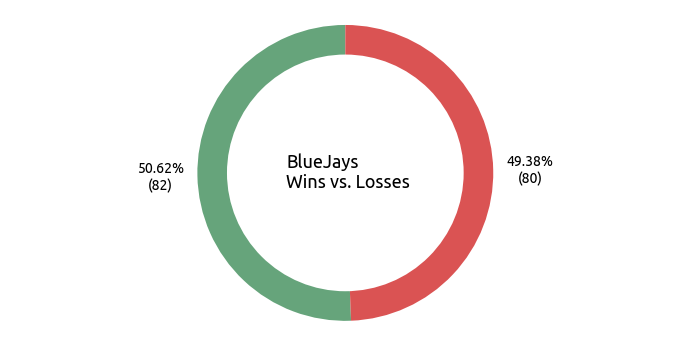

In [27]:
# win and loss percentage - pie chart
labels = ['', '']
sizes = [totalWins, totalLosses]
colours = ["#66a47b", "#da5353"]
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['font.family'] = 'Ubuntu'
plt.rcParams['font.size'] = 14
fig1, ax1 = plt.subplots()
patches, texts, autotexts = ax1.pie(sizes, labels=labels, autopct='%1.2f%%', startangle=90, pctdistance=1.25, colors=colours)
autotexts[0].set_text(autotexts[0].get_text() + "\n(" + str(totalWins) + ")")
autotexts[1].set_text(autotexts[1].get_text() + "\n(" + str(totalLosses) + ")") 
circle = plt.Circle((0, 0), 0.8, fc='white')
text = plt.text(-0.4, -0.1, f'{teamName}\nWins vs. Losses', fontsize=18)
p = plt.gcf() # get current reference
p.gca().add_artist(circle)
ax1.axis('equal')
plt.show()

In [28]:
print('Most wins against', maxWinTeams)
print('Most losses against', maxLoseTeams)

Most wins against ['RedSox']
Most losses against ['Orioles']


In [29]:
allColours = {
    "Cubs": "#CC3433",
    "Dodgers": "#EF3E42",
    "Cardinals": "#C41E3A",
    "Mets": "#FF5910",
    "Pirates": "#FDB827",
    "Nationals": "#AB0003",
    "Braves": "#CE1141",
    "Brewers": "#B6922E",
    "Reds": "#C6011F",
    "Philies": "#284898",
    "Giants": "#FD5A1E",
    "Rockies": "#333366",
    "Diamondbacks": "#A71930",
    "Padres": "#002D62",
    "Marlins": "#FF6600",
    "Yankees": "#E4002B",
    "RedSox": "#BD3039",
    "Indians": "#E31937",
    "Astros": "#EB6E1F",
    "WhiteSox": "#000000",
    "Athletics": "#003831",
    "Orioles": "#DF4601",
    "Rays": "#092C5C",
    "Angels": "#BA0021",
    "BlueJays": "#134A8E",
    "Twins": "#002B5C",
    "Royals": "#C09A5B",
    "Mariners": "#005C5C",
    "Rangers": "#C0111F",
    "Tigers": "#0C2C56"
}
barColours = []
for key in list(records.keys()):
    for team, colour in allColours.items():
        if key == team:
            barColours.append(colour)

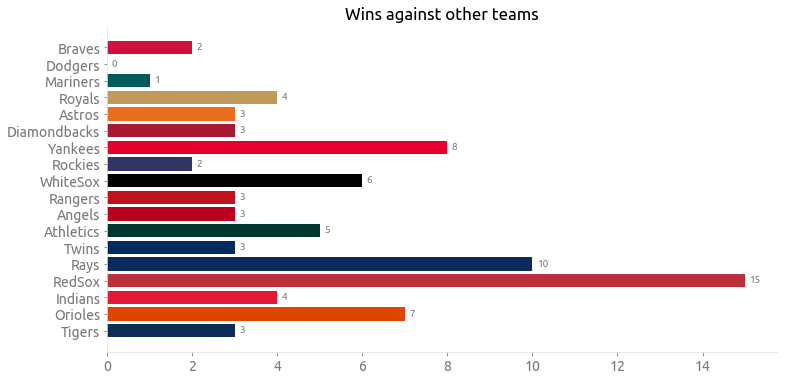

In [30]:
fig2, ax2 = plt.subplots()
plt.title('Wins against other teams')
teams = list(records.keys())
wins = list(list(records.values())[i][0] for i in range(len(records)))
y = list(range(len(teams)))
for i in range(len(wins)):
    ax2.text(wins[i] + 0.1, i - 0.125, str(wins[i]), fontsize=10, color = "#7a7a7a")
ax2.barh(y, wins, label=wins, color=barColours)
ax2.spines['bottom'].set_color('#e1e1e1')
ax2.spines['top'].set_color('white') 
ax2.spines['right'].set_color('white')
ax2.spines['left'].set_color('#e1e1e1')
ax2.tick_params(axis='x', colors='#7a7a7a')
ax2.tick_params(axis='y', colors='#7a7a7a')
ax2.set_yticks(y)
ax2.set_yticklabels(teams)
plt.show()